<a href="https://colab.research.google.com/github/megha1906/CompetitiveCoding/blob/master/Transfer_Learning_using_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.applications import vgg16

# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
vgg = vgg16.VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)
    
 
def lw(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model 
    
    
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set our class number to 3 (Young, Middle, Old)
num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())

Using TensorFlow backend.


58892288/58889256 [==============================] - 2s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0      

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/drive/My Drive/photos/photos/train'
validation_data_dir = '/content/drive/My Drive/photos/photos/validate'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=45,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
# set our batch size (typically on most mid tier systems we'll use 16-32)
batch_size = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical')
        
        
        

Found 539 images belonging to 2 classes.
Found 303 images belonging to 2 classes.


In [5]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("face recognisation.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

# Enter the number of training and validation samples here
nb_train_samples = 108
nb_validation_samples = 52

# We only train 5 EPOCHS 
epochs = 5
batch_size = 16

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)
    

Epoch 1/5
6/6 [==============================] - 96s 16s/step - loss: 1.7088 - accuracy: 0.4635 - val_loss: 0.6719 - val_accuracy: 0.5312

Epoch 00001: val_loss improved from inf to 0.67187, saving model to face recognisation.h5
Epoch 2/5
6/6 [==============================] - 91s 15s/step - loss: 0.7186 - accuracy: 0.4740 - val_loss: 0.7069 - val_accuracy: 0.4375

Epoch 00002: val_loss did not improve from 0.67187
Epoch 3/5
6/6 [==============================] - 74s 12s/step - loss: 0.6796 - accuracy: 0.5348 - val_loss: 1.0478 - val_accuracy: 0.4792

Epoch 00003: val_loss did not improve from 0.67187
Epoch 4/5
6/6 [==============================] - 4s 662ms/step - loss: 0.7252 - accuracy: 0.5365 - val_loss: 0.6852 - val_accuracy: 0.6456
Restoring model weights from the end of the best epoch

Epoch 00004: val_loss did not improve from 0.67187
Epoch 00004: early stopping


Class - aamir 


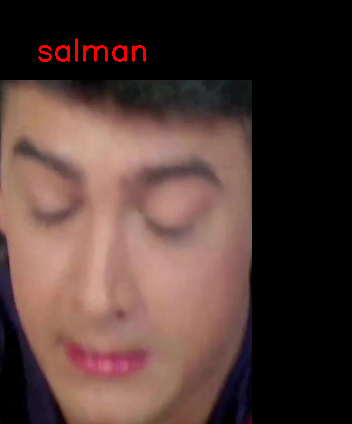

Class - aamir 


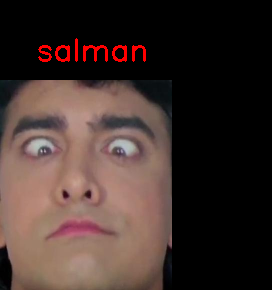

Class - aamir 


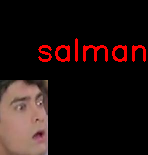

Class -  salman


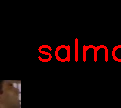

Class - aamir 


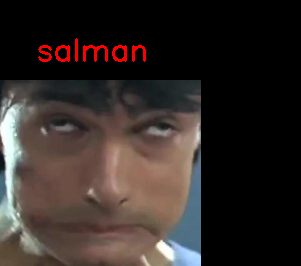

Class -  salman


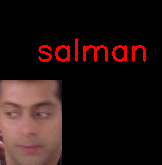

Class -  salman


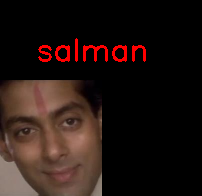

Class - aamir 


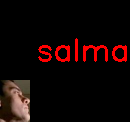

Class -  salman


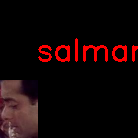

Class - aamir 


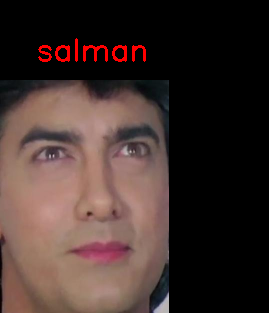

In [8]:
from keras.models import load_model

classifier = load_model('/content/face recognisation.h5')

import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from os import listdir
from os.path import isfile, join

monkey_breeds_dict = {"[0]": " salman ", 
                      "[1]": "aamir "}

monkey_breeds_dict_n = {"n0": " salman", 
                      "n1": "aamir "}

def draw_test(name, pred, im):
    monkey = monkey_breeds_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, monkey, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow(expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + monkey_breeds_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/content/drive/My Drive/photos/photos/validate/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()